In [3]:
!pip install PyWavelets

In [4]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import urllib.request
import shutil
import pywt
from sklearn.decomposition import PCA

from google.colab import drive

drive.mount('/content/drive')

# Change working directory to dataset location
os.chdir("/content/drive/MyDrive/project/E02/test_images")

def download_cascades():
    face_url = "https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml"
    eye_url = "https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_eye.xml"
    urllib.request.urlretrieve(face_url, "haarcascade_frontalface_default.xml")
    urllib.request.urlretrieve(eye_url, "haarcascade_eye.xml")

download_cascades()

face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("haarcascade_eye.xml")

def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
    return None

# Define dataset paths
path_to_data = "/content/drive/MyDrive/project/E02/Dataset/"
path_to_cr_data = os.path.join(path_to_data, "cropped")



# Create cropped images directory
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

img_dirs = [entry.path for entry in os.scandir(path_to_data) if entry.is_dir()]

entreprenure_file_names_dict = {}
cropped_image_dirs = []

for img_dir in img_dirs:
    entreprenure_name = os.path.basename(img_dir)
    print(f"Processing {entreprenure_name}...")
    entreprenure_file_names_dict[entreprenure_name] = []
    count = 1

    for entry in os.scandir(img_dir):
        if entry.is_file() and entry.name.lower().endswith(('.jpg', '.jpeg', '.png')):
            roi_color = get_cropped_image_if_2_eyes(entry.path)
            if roi_color is not None:
                cropped_folder = os.path.join(path_to_cr_data, entreprenure_name)
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print(f"Generating cropped images in: {cropped_folder}")

                cropped_file_name = f"{entreprenure_name}{count}.png"
                cropped_file_path = os.path.join(cropped_folder, cropped_file_name)

                cv2.imwrite(cropped_file_path, roi_color)
                entreprenure_file_names_dict[entreprenure_name].append(cropped_file_path)
                count += 1

Mounted at /content/drive
Processing Mark Zuckerberg...
Generating cropped images in: /content/drive/MyDrive/project/E02/Dataset/cropped/Mark Zuckerberg
Processing Steve Jobs...
Generating cropped images in: /content/drive/MyDrive/project/E02/Dataset/cropped/Steve Jobs
Processing Jack Ma...
Generating cropped images in: /content/drive/MyDrive/project/E02/Dataset/cropped/Jack Ma
Processing Jeff Bezos...
Generating cropped images in: /content/drive/MyDrive/project/E02/Dataset/cropped/Jeff Bezos
Processing Elon Musk...
Generating cropped images in: /content/drive/MyDrive/project/E02/Dataset/cropped/Elon Musk
Processing cropped...


In [5]:
import random
import numpy as np
import cv2
import pywt
import os # Ensure os is imported for listdir

def w2d(img, mode='haar', level=1):
    imArray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imArray = np.float32(imArray) / 255
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    imArray_H = pywt.waverec2(coeffs_H, mode) * 255
    return np.uint8(imArray_H)

def random_augmentation(img):
    augmented_images = []

    augmented_images.append(img)  # original

    augmented_images.append(cv2.flip(img, 1))  # horizontal flip
    augmented_images.append(cv2.flip(img, 0))  # vertical flip

    augmented_images.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))
    augmented_images.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))

    rows, cols = img.shape[:2]
    angle = random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated = cv2.warpAffine(img, M, (cols, rows))
    augmented_images.append(rotated)

    noise = np.random.normal(0, 0.05, img.shape)
    noisy_img = np.clip(img/255 + noise, 0, 1) * 255
    noisy_img = noisy_img.astype(np.uint8)
    augmented_images.append(noisy_img)

    value = random.randint(-30, 30)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:,:,2] = cv2.add(hsv[:,:,2], value)
    bright_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    augmented_images.append(bright_img)

    zoom_factor = random.uniform(0.8, 1.2)
    if zoom_factor != 1:
        center = (cols//2, rows//2)
        M_zoom = cv2.getRotationMatrix2D(center, 0, zoom_factor)
        zoomed_img = cv2.warpAffine(img, M_zoom, (cols, rows))
        augmented_images.append(zoomed_img)

    crop_scale = random.uniform(0.8, 1.0)
    new_rows, new_cols = int(rows * crop_scale), int(cols * crop_scale)
    start_row = random.randint(0, rows - new_rows)
    start_col = random.randint(0, cols - new_cols)
    cropped_img = img[start_row:start_row+new_rows, start_col:start_col+new_cols]
    cropped_img = cv2.resize(cropped_img, (cols, rows))
    augmented_images.append(cropped_img)

    return augmented_images

# Define the path to the cropped data directory
path_to_cr_data = "/content/drive/MyDrive/project/E02/Dataset/cropped"

# Create class dictionary by mapping directory names to integers
class_dict = {}
count = 0
for dir_name in os.listdir(path_to_cr_data):
    if os.path.isdir(os.path.join(path_to_cr_data, dir_name)):
        class_dict[dir_name] = count
        count += 1

# Print the class dictionary to verify
print("Class Dictionary:", class_dict)

# class_dict is now defined
x, y = [], []

for entreprenure_name, training_files in entreprenure_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            print(f"Error reading {training_image}")
            continue

        augmented_images = random_augmentation(img)

        for aug_img in augmented_images:
            scaled_raw_img = cv2.resize(aug_img, (32, 32))
            # Make sure the image is not None before applying w2d
            if scaled_raw_img is not None:
                img_har = w2d(aug_img, 'db1', 5)
                scaled_img = cv2.resize(img_har, (32, 32))

                combined_img = np.vstack((
                    scaled_raw_img.reshape(32 * 32 * 3, 1),
                    scaled_img.reshape(32 * 32, 1)
                ))

                x.append(combined_img)
                # Use the defined class_dict here
                if entreprenure_name in class_dict:
                     y.append(class_dict[entreprenure_name])
                else:
                     print(f"Warning: '{entreprenure_name}' not found in class_dict. Skipping image.")


print(f"Dataset size after augmentation: {len(x)} images")

Class Dictionary: {'Mark Zuckerberg': 0, 'Steve Jobs': 1, 'Jack Ma': 2, 'Jeff Bezos': 3, 'Elon Musk': 4}
Dataset size after augmentation: 570 images


In [6]:
len(x)
len(y)
len(x[0])


4096

In [7]:
32*32*3 + 32*32

4096

In [8]:
x[0]

array([[  6],
       [  6],
       [  6],
       ...,
       [121],
       [127],
       [127]], dtype=uint8)

In [9]:
x = np. array(x).reshape(len(x), 4096).astype(float)
x.shape

(570, 4096)

In [10]:

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


In [11]:
# Improved train-test split
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0, stratify=y
)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('svc', SVC(C=0.01, kernel='rbf', gamma='scale'))
])


# Train and evaluate
pipe.fit(X_train, y_train)
print("Test accuracy:", pipe.score(X_test, y_test))

Test accuracy: 0.3157894736842105


In [12]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        14
           4       0.32      1.00      0.48        36

    accuracy                           0.32       114
   macro avg       0.06      0.20      0.10       114
weighted avg       0.10      0.32      0.15       114



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [14]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto', probability=True),
        'params': {
            'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'svc__kernel': ['rbf', 'linear'],
            'pca__n_components': [20, 50, 80, 100]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [50, 100, 200],
            'randomforestclassifier__max_depth': [5, 10, 20, None],
            'randomforestclassifier__min_samples_split': [2, 5, 10],
            'pca__n_components': [20, 50, 80, 100]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'logisticregression__C': [0.001, 0.01, 0.1, 1, 5, 10],
            'pca__n_components': [20, 50, 80, 100]
        }
    }
}

scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), PCA(), mp['model']) # PCA components will be tuned by GridSearchCV
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False, n_jobs=-1) # Use n_jobs=-1 for parallel processing
    clf.fit(X_train, y_train)

    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
print(df)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                 model  best_score  \
0                  svm    0.839943   
1        random_forest    0.767630   
2  logistic_regression    0.807143   

                                         best_params  
0  {'pca__n_components': 100, 'svc__C': 0.001, 's...  
1  {'pca__n_components': 50, 'randomforestclassif...  
2  {'logisticregression__C': 10, 'pca__n_componen...  


In [15]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('pca', PCA(n_components=100)),
                 ('svc',
                  SVC(C=0.001, gamma='auto', kernel='linear',
                      probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('pca', PCA(n_components=50)),
                 ('randomforestclassifier',
                  RandomForestClassifier(max_depth=20))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('pca', PCA(n_components=100)),
                 ('logisticregression',
                  LogisticRegression(C=10, multi_class='auto',
                                     solver='liblinear'))])}

In [16]:
best_estimators['svm'].score(X_test,y_test)

0.8070175438596491

In [17]:
best_estimators['random_forest'].score(X_test,y_test)

0.7543859649122807

In [18]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7894736842105263

In [19]:
best_model_name = max(best_estimators, key=lambda k: best_estimators[k].score(X_test, y_test))
best_model = best_estimators[best_model_name]
print(f"Best individual model is {best_model_name} with test accuracy: {best_model.score(X_test, y_test)*100:.2f}%")


Best individual model is svm with test accuracy: 80.70%


In [20]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('svm', best_estimators['svm']),
    ('rf', best_estimators['random_forest']),
    ('lr', best_estimators['logistic_regression'])
], voting='hard')

ensemble.fit(X_train, y_train)
ensemble_accuracy = ensemble.score(X_test, y_test)
print(f"Ensemble Test Accuracy: {ensemble_accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Ensemble Test Accuracy: 79.82%


In [21]:
#check training and testing accuracy in %

print(f"Training Accuracy: {best_model.score(X_train, y_train) * 100:.2f}%")
print(f"Testing Accuracy: {best_model.score(X_test, y_test) * 100:.2f}%")

Training Accuracy: 96.71%
Testing Accuracy: 80.70%


In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))
cm

array([[28,  1,  0,  1,  0],
       [ 1, 14,  0,  0,  3],
       [ 1,  0, 11,  2,  2],
       [ 1,  0,  4,  5,  4],
       [ 2,  0,  0,  0, 34]])

Text(95.72222222222221, 0.5, 'Truth')

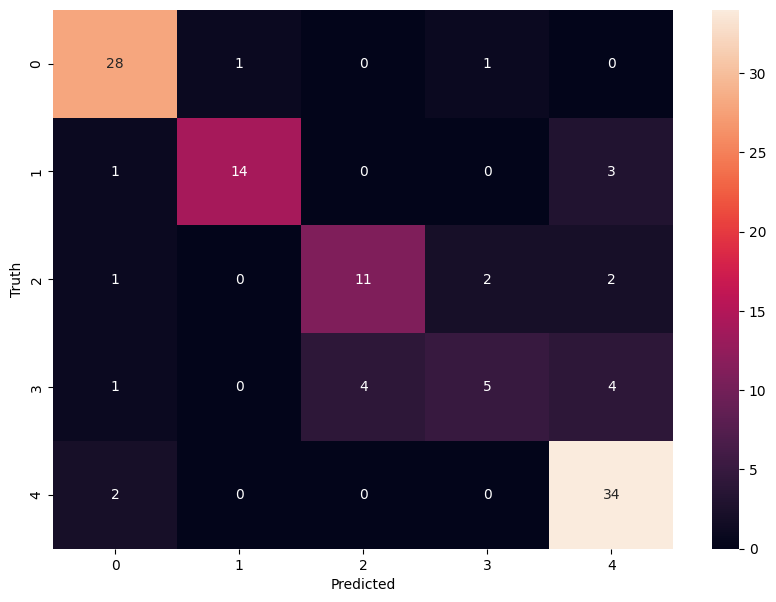

In [23]:

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [24]:
class_dict

{'Mark Zuckerberg': 0,
 'Steve Jobs': 1,
 'Jack Ma': 2,
 'Jeff Bezos': 3,
 'Elon Musk': 4}

In [25]:
!pip install joblib
import joblib
# Save the model as a pickle in a file
joblib.dump(best_model, 'saved_model.pkl')

['saved_model.pkl']

In [26]:
import json
import joblib

with open("class_dictionary.json","w") as f:
    json.dump(class_dict, f)


In [27]:
#check training and testing accuracy in %

print(f"Training Accuracy: {best_model.score(X_train, y_train) * 100:.2f}%")
print(f"Testing Accuracy: {best_model.score(X_test, y_test) * 100:.2f}%")

Training Accuracy: 96.71%
Testing Accuracy: 80.70%


In [28]:
# prompt: i want to check training and test accuracy for each model one by one

# Evaluate training and test accuracy for each model individually

print("\n--- Individual Model Accuracies ---")

# SVM
print(f"SVM Training Accuracy: {best_estimators['svm'].score(X_train, y_train) * 100:.2f}%")
print(f"SVM Testing Accuracy: {best_estimators['svm'].score(X_test, y_test) * 100:.2f}%")

# Random Forest
print(f"Random Forest Training Accuracy: {best_estimators['random_forest'].score(X_train, y_train) * 100:.2f}%")
print(f"Random Forest Testing Accuracy: {best_estimators['random_forest'].score(X_test, y_test) * 100:.2f}%")

# Logistic Regression
print(f"Logistic Regression Training Accuracy: {best_estimators['logistic_regression'].score(X_train, y_train) * 100:.2f}%")
print(f"Logistic Regression Testing Accuracy: {best_estimators['logistic_regression'].score(X_test, y_test) * 100:.2f}%")

print("\n--- Best Individual Model Accuracy ---")
print(f"Best individual model ({best_model_name}) Training Accuracy: {best_model.score(X_train, y_train) * 100:.2f}%")
print(f"Best individual model ({best_model_name}) Testing Accuracy: {best_model.score(X_test, y_test) * 100:.2f}%")

print("\n--- Ensemble Model Accuracy ---")
print(f"Ensemble Training Accuracy: {ensemble.score(X_train, y_train) * 100:.2f}%")
print(f"Ensemble Testing Accuracy: {ensemble.score(X_test, y_test) * 100:.2f}%")




--- Individual Model Accuracies ---
SVM Training Accuracy: 96.71%
SVM Testing Accuracy: 80.70%
Random Forest Training Accuracy: 100.00%
Random Forest Testing Accuracy: 75.44%
Logistic Regression Training Accuracy: 100.00%
Logistic Regression Testing Accuracy: 78.95%

--- Best Individual Model Accuracy ---
Best individual model (svm) Training Accuracy: 96.71%
Best individual model (svm) Testing Accuracy: 80.70%

--- Ensemble Model Accuracy ---
Ensemble Training Accuracy: 100.00%
Ensemble Testing Accuracy: 79.82%


The image is classified as: Mark Zuckerberg


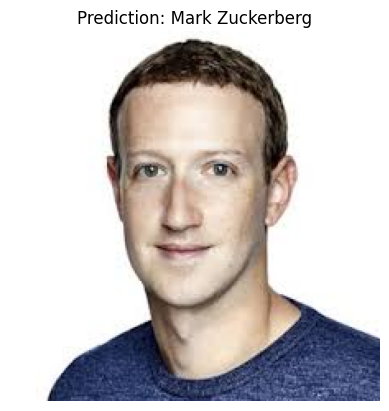

In [29]:
import cv2
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt

# Load the trained model
loaded_model = joblib.load('saved_model.pkl')

# Load the class dictionary
with open('class_dictionary.json', 'r') as f:
    class_dict = json.load(f)

# Create a reverse mapping from index to celebrity name
class_name_dict = {v: k for k, v in class_dict.items()}

def w2d(img, mode='haar', level=1):
    imArray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imArray = np.float32(imArray) / 255
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    imArray_H = pywt.waverec2(coeffs_H, mode) * 255
    return np.uint8(imArray_H)

def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
    return None

def classify_image(image_path, model, class_name_mapping):
    # 1. Load and preprocess the image
    cropped_img = get_cropped_image_if_2_eyes(image_path)

    if cropped_img is None:
        return "Could not detect a face with two eyes in the image."

    # Apply the same preprocessing as during training
    scaled_raw_img = cv2.resize(cropped_img, (32, 32))
    img_har = w2d(cropped_img, 'db1', 5)
    scaled_img = cv2.resize(img_har, (32, 32))

    combined_img = np.vstack((
        scaled_raw_img.reshape(32 * 32 * 3, 1),
        scaled_img.reshape(32 * 32, 1)
    ))

    # Reshape for prediction
    input_data = np.array(combined_img).reshape(1, 4096).astype(float)

    # 2. Make a prediction
    prediction_index = model.predict(input_data)[0]

    # 3. Get the celebrity name
    predicted_class_name = class_name_mapping.get(prediction_index, "Unknown Celebrity")

    return predicted_class_name

# Define the path to the test image
test_image_path = '/content/drive/MyDrive/project/E02/test_images/Mark1.jpeg'

# Classify the test image
predicted_celebrity = classify_image(test_image_path, loaded_model, class_name_dict)
print(f"The image is classified as: {predicted_celebrity}")

# Visualize the test image and prediction result
img = cv2.imread(test_image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {predicted_celebrity}")
plt.axis('off')
plt.show()


The image is classified as: Jeff Bezos


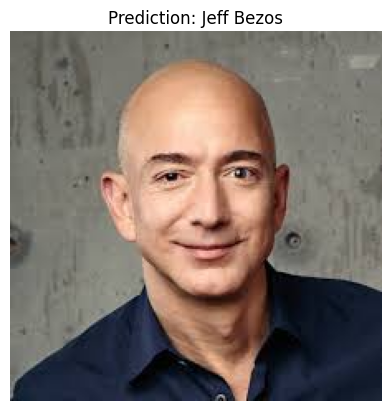

In [30]:

# Define the path to the test image
test_image_path = '/content/drive/MyDrive/project/E02/test_images/jeff.jpeg'

# Classify the test image
predicted_celebrity = classify_image(test_image_path, loaded_model, class_name_dict)
print(f"The image is classified as: {predicted_celebrity}")

# Visualize the test image and prediction result
img = cv2.imread(test_image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {predicted_celebrity}")
plt.axis('off')
plt.show()


The image is classified as: Could not detect a face with two eyes in the image.


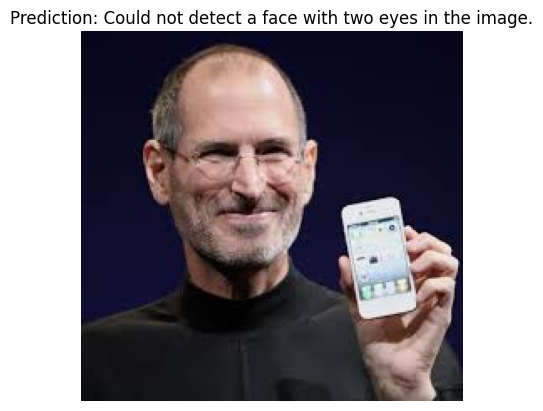

In [31]:

# Define the path to the test image
test_image_path = '/content/drive/MyDrive/project/E02/test_images/steve.jpeg'

# Classify the test image
predicted_celebrity = classify_image(test_image_path, loaded_model, class_name_dict)
print(f"The image is classified as: {predicted_celebrity}")

# Visualize the test image and prediction result
img = cv2.imread(test_image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {predicted_celebrity}")
plt.axis('off')
plt.show()


#Final Conclusion.


Here used the eye based recognition. when the image not showing the eye properly it can not predict.